<a href="https://colab.research.google.com/github/EggBert001/AI-Bootcamp/blob/master/knowledge_graph_pipeline_langgraph_networkx_Marktechpost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langgraph langchain_core

In [ ]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from typing import TypedDict, List, Tuple, Dict, Any
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, END

In [ ]:
class KGState(TypedDict):
    topic: str
    raw_text: str
    entities: List[str]
    relations: List[Tuple[str, str, str]]
    resolved_relations: List[Tuple[str, str, str]]
    graph: Any
    validation: Dict[str, Any]
    messages: List[Any]
    current_agent: str

In [ ]:
def data_gatherer(state: KGState) -> KGState:
    topic = state["topic"]
    print(f"📚 Data Gatherer: Searching for information about '{topic}'")

    collected_text = f"{topic} is an important concept. It relates to various entities like EntityA, EntityB, and EntityC. EntityA influences EntityB. EntityC is a type of EntityB."

    state["messages"].append(AIMessage(content=f"Collected raw text about {topic}"))

    state["raw_text"] = collected_text
    state["current_agent"] = "entity_extractor"

    return state

In [ ]:
def entity_extractor(state: KGState) -> KGState:
    print("🔍 Entity Extractor: Identifying entities in the text")
    text = state["raw_text"]

    entities = re.findall(r"Entity[A-Z]", text)

    entities = [state["topic"]] + entities
    state["entities"] = list(set(entities))

    state["messages"].append(AIMessage(content=f"Extracted entities: {state['entities']}"))
    print(f"   Found entities: {state['entities']}")

    state["current_agent"] = "relation_extractor"

    return state

In [ ]:
def relation_extractor(state: KGState) -> KGState:
    print("🔗 Relation Extractor: Identifying relationships between entities")
    text = state["raw_text"]
    entities = state["entities"]
    relations = []

    relation_patterns = [
        (r"([A-Za-z]+) relates to ([A-Za-z]+)", "relates_to"),
        (r"([A-Za-z]+) influences ([A-Za-z]+)", "influences"),
        (r"([A-Za-z]+) is a type of ([A-Za-z]+)", "is_type_of")
    ]

    for e1 in entities:
        for e2 in entities:
            if e1 != e2:
                for pattern, rel_type in relation_patterns:
                    if re.search(f"{e1}.*{rel_type}.*{e2}", text.replace("_", " "), re.IGNORECASE) or \
                       re.search(f"{e1}.*{e2}", text, re.IGNORECASE):
                        relations.append((e1, rel_type, e2))

    state["relations"] = relations
    state["messages"].append(AIMessage(content=f"Extracted relations: {relations}"))
    print(f"   Found relations: {relations}")

    state["current_agent"] = "entity_resolver"

    return state

In [ ]:
def entity_resolver(state: KGState) -> KGState:
    print("🔄 Entity Resolver: Resolving duplicate entities")

    entity_map = {}
    for entity in state["entities"]:
        canonical_name = entity.lower().replace(" ", "_")
        entity_map[entity] = canonical_name

    resolved_relations = []
    for s, p, o in state["relations"]:
        s_resolved = entity_map.get(s, s)
        o_resolved = entity_map.get(o, o)
        resolved_relations.append((s_resolved, p, o_resolved))

    state["resolved_relations"] = resolved_relations
    state["messages"].append(AIMessage(content=f"Resolved relations: {resolved_relations}"))

    state["current_agent"] = "graph_integrator"

    return state

In [ ]:
def graph_integrator(state: KGState) -> KGState:
    print("📊 Graph Integrator: Building the knowledge graph")
    G = nx.DiGraph()

    for s, p, o in state["resolved_relations"]:
        if not G.has_node(s):
            G.add_node(s)
        if not G.has_node(o):
            G.add_node(o)
        G.add_edge(s, o, relation=p)

    state["graph"] = G
    state["messages"].append(AIMessage(content=f"Built graph with {len(G.nodes)} nodes and {len(G.edges)} edges"))

    state["current_agent"] = "graph_validator"

    return state

In [ ]:
def graph_validator(state: KGState) -> KGState:
    print("✅ Graph Validator: Validating knowledge graph")
    G = state["graph"]

    validation_report = {
        "num_nodes": len(G.nodes),
        "num_edges": len(G.edges),
        "is_connected": nx.is_weakly_connected(G) if G.nodes else False,
        "has_cycles": not nx.is_directed_acyclic_graph(G) if G.nodes else False
    }

    state["validation"] = validation_report
    state["messages"].append(AIMessage(content=f"Validation report: {validation_report}"))
    print(f"   Validation report: {validation_report}")

    state["current_agent"] = END

    return state

In [ ]:
def router(state: KGState) -> str:
    return state["current_agent"]

def visualize_graph(graph):
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(graph)

    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10)

    edge_labels = nx.get_edge_attributes(graph, 'relation')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

    plt.title("Knowledge Graph")
    plt.tight_layout()
    plt.show()

In [ ]:
def build_kg_graph():
    workflow = StateGraph(KGState)

    workflow.add_node("data_gatherer", data_gatherer)
    workflow.add_node("entity_extractor", entity_extractor)
    workflow.add_node("relation_extractor", relation_extractor)
    workflow.add_node("entity_resolver", entity_resolver)
    workflow.add_node("graph_integrator", graph_integrator)
    workflow.add_node("graph_validator", graph_validator)

    workflow.add_conditional_edges("data_gatherer", router,
                                {"entity_extractor": "entity_extractor"})
    workflow.add_conditional_edges("entity_extractor", router,
                                {"relation_extractor": "relation_extractor"})
    workflow.add_conditional_edges("relation_extractor", router,
                                {"entity_resolver": "entity_resolver"})
    workflow.add_conditional_edges("entity_resolver", router,
                                {"graph_integrator": "graph_integrator"})
    workflow.add_conditional_edges("graph_integrator", router,
                                {"graph_validator": "graph_validator"})
    workflow.add_conditional_edges("graph_validator", router,
                                {END: END})

    workflow.set_entry_point("data_gatherer")

    return workflow.compile()

In [ ]:
def run_knowledge_graph_pipeline(topic):
    print(f"🚀 Starting knowledge graph pipeline for: {topic}")

    initial_state = {
        "topic": topic,
        "raw_text": "",
        "entities": [],
        "relations": [],
        "resolved_relations": [],
        "graph": None,
        "validation": {},
        "messages": [HumanMessage(content=f"Build a knowledge graph about {topic}")],
        "current_agent": "data_gatherer"
    }

    kg_app = build_kg_graph()
    final_state = kg_app.invoke(initial_state)

    print(f"✨ Knowledge graph construction complete for: {topic}")

    return final_state

🚀 Starting knowledge graph pipeline for: Artificial Intelligence
📚 Data Gatherer: Searching for information about 'Artificial Intelligence'
🔍 Entity Extractor: Identifying entities in the text
   Found entities: ['Artificial Intelligence', 'EntityB', 'EntityC', 'EntityA']
🔗 Relation Extractor: Identifying relationships between entities
   Found relations: [('Artificial Intelligence', 'relates_to', 'EntityB'), ('Artificial Intelligence', 'influences', 'EntityB'), ('Artificial Intelligence', 'is_type_of', 'EntityB'), ('Artificial Intelligence', 'relates_to', 'EntityC'), ('Artificial Intelligence', 'influences', 'EntityC'), ('Artificial Intelligence', 'is_type_of', 'EntityC'), ('Artificial Intelligence', 'relates_to', 'EntityA'), ('Artificial Intelligence', 'influences', 'EntityA'), ('Artificial Intelligence', 'is_type_of', 'EntityA'), ('EntityB', 'relates_to', 'EntityC'), ('EntityB', 'influences', 'EntityC'), ('EntityB', 'is_type_of', 'EntityC'), ('EntityB', 'relates_to', 'EntityA'), ('E

<ipython-input-19-502cc678a95a>:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


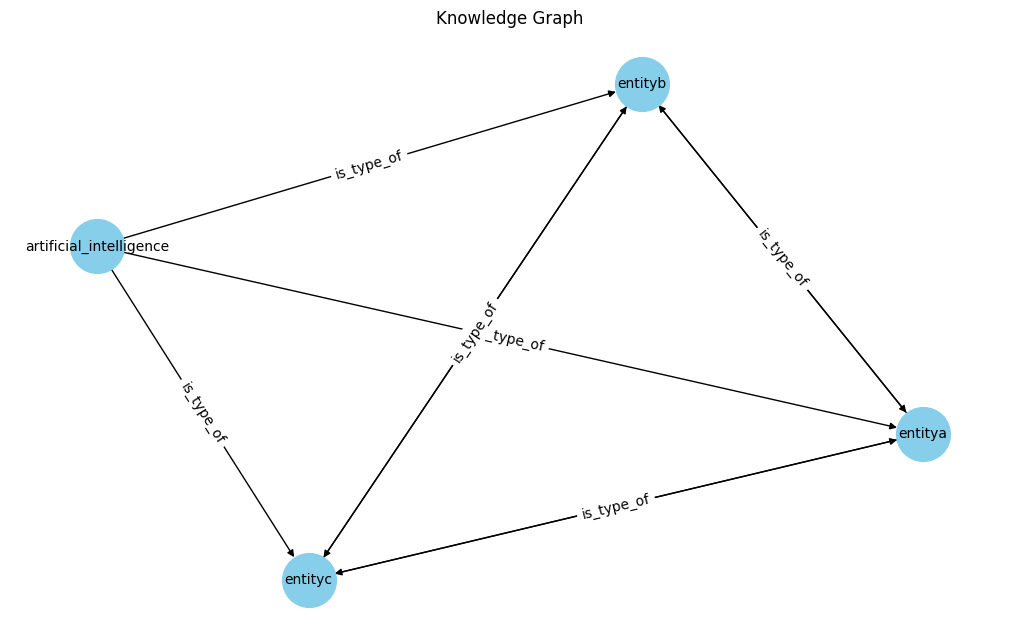

In [ ]:
if __name__ == "__main__":
    topic = "Artificial Intelligence"
    result = run_knowledge_graph_pipeline(topic)

    visualize_graph(result["graph"])